In [16]:
from __future__ import division, print_function, absolute_import

import tensorflow.compat.v1 as tf
import random
import tflearn
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from scipy import spatial

In [226]:
from nltk.corpus import wordnet

In [227]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kalliehuynh/nltk_data...


True

In [3]:
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [233]:
# Load data
print('loading data...')
data = pd.read_csv('BERT_trainingset2.csv')

cp_words = list(data.iloc[:, 1])
0
# Embeddings Dict
print('creating embeddings dictionary...')
embeddings = pd.read_csv('/Users/kalliehuynh/compound-word-embeddings/BERT_embeddings.csv')
embeddings_dict = {}
for i in embeddings.index:
    embeddings_dict[embeddings.iloc[i, 1]] = np.array(embeddings.iloc[i, 2:], dtype='float32')


loading data...
creating embeddings dictionary...


In [133]:
def find_closest_embeddings(embedding):
    
    return sorted(embeddings_dict.keys(), key=lambda word: np.linalg.norm(embeddings_dict[word] - embedding))
 
def closest_cosine_similarity(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.cosine(embeddings_dict[word], embedding))    

In [6]:
rows = len(data)

df = data.copy()
df = df.sample(frac=1).reset_index(drop=True)


np_array = np.array(df)
train_rows = round(len(df)*0.7)
test_rows = rows  - train_rows

trainX = np.array(df.iloc[:train_rows, 4:1540], dtype="float32")  # The vectors for the constituent words
set_trainX = set(df.iloc[:train_rows, 4:1540])

trainY = np.array(df.iloc[:train_rows, 1540:], dtype="float32")  # The vector for the compound word

testX = np.array(df.iloc[train_rows:, 4:1540], dtype="float32")
testY = np.array(df.iloc[train_rows:, 1540:], dtype="float32")
print('testX shape:', testX.shape)
print('testY shape:', testY.shape)

print('loading data complete!')

testX shape: (85, 1536)
testY shape: (85, 768)
loading data complete!


In [7]:
# Reshape the input for LSTM
print('data reshaping...')
trainX = trainX.reshape((train_rows, 2, 768))
testX = testX.reshape(testX.shape[0], 2, 768)
print('data reshaping complete!')

data reshaping...
data reshaping complete!


In [ ]:
def cosine_similarity(y_pred, y_true):
    with tf.name_scope("Similarity"):
        dot_product = tf.reduce_sum(tf.math.multiply(y_pred,y_true),axis=1)

        pred_magnitudes = tf.sqrt(tf.reduce_sum(tf.math.multiply(y_pred,y_pred),axis=1))
        true_magnitudes = tf.sqrt(tf.reduce_sum(tf.math.multiply(y_true,y_true),axis=1))

        cos = dot_product/(pred_magnitudes * true_magnitudes)

        return tf.math.abs(tf.reduce_mean(cos) - 1)

def mean_square(y_pred, y_true):
    """ Mean Square Loss.

    Arguments:
        y_pred: `Tensor` of `float` type. Predicted values.
        y_true: `Tensor` of `float` type. Targets (labels).

    """
    with tf.name_scope("MeanSquare"):
        return tf.reduce_mean(tf.square(y_pred - y_true))

def custom_loss(y_pred, y_true):
    alpha = 0.05
    cosine_loss = cosine_similarity(y_pred, y_true)
    mean_square_loss = mean_square(y_pred, y_true)

    loss = tf.cond(cosine_loss<alpha,
                            lambda: 0.75*cosine_loss + 0.25*mean_square_loss,
                            lambda: cosine_loss)
    return loss

In [365]:
tf.reset_default_graph()

In [366]:
# Network building
batch_size = 4
learning_rate = 0.0005
print('network building...')
net = tflearn.input_data(shape=[None, 2, 768])  
net = tflearn.lstm(net, 768) 
net = tflearn.layers.core.dropout(net, 0.70)
net = tflearn.fully_connected(net, 768, restore=False) 
net = tflearn.regression(net, optimizer='adam', batch_size=batch_size, learning_rate=learning_rate, loss='custom_loss')

network building...


In [367]:
# Training
print('training...')
model = tflearn.DNN(net, tensorboard_verbose=0, best_checkpoint_path='model_finetuning', max_checkpoints=3)

training...


In [349]:
model.fit(trainX, trainY, 
    validation_set=(testX, testY), 
    n_epoch=100, 
    show_metric=True,
    run_id='fine_tuning!')

Training Step: 799  | total loss: 0.57314 | time: 0.021s
| Adam | epoch: 200 | loss: 0.57314 - acc: 0.1599 -- iter: 192/198
Training Step: 800  | total loss: 0.57250 | time: 1.032s
| Adam | epoch: 200 | loss: 0.57250 - acc: 0.1605 | val_loss: 0.57161 - val_acc: 0.2000 -- iter: 198/198
--


test acc: [0.20000000298023224]
Generate predictions for  5  samples
predictions shape: (5, 768)


PREDICTED EMBEDDING
c1         pit
c2        fall
cmp    pitfall
Name: 198, dtype: object ['one', 'since', 'although', 'acting', 'solid']
closest cosine distance to the prediction: 0.6367340981960297, 0.6407382488250732
c1          button
c2           holes
cmp    buttonholes
Name: 199, dtype: object ['one', 'since', 'although', 'acting', 'solid']
closest cosine distance to the prediction: 0.6367440223693848, 0.6405092477798462
c1           master
c2           pieces
cmp    masterpieces
Name: 200, dtype: object ['one', 'since', 'although', 'acting', 'solid']
closest cosine distance to the prediction: 0.6433016061782837, 0.6471279561519623
c1         back
c2         side
cmp    backside
Name: 201, dtype: object ['one', 'since', 'although', 'acting', 'solid']
closest cosine distance to the prediction: 0.6465586721897125, 0.6522055864334106
c1          bride
c2          groom
cmp    bridegro

/Users/kalliehuynh/miniforge3/envs/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kalliehuynh/miniforge3/envs/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/kalliehuynh/miniforge3/envs/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/kalliehuynh/miniforge3/envs/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


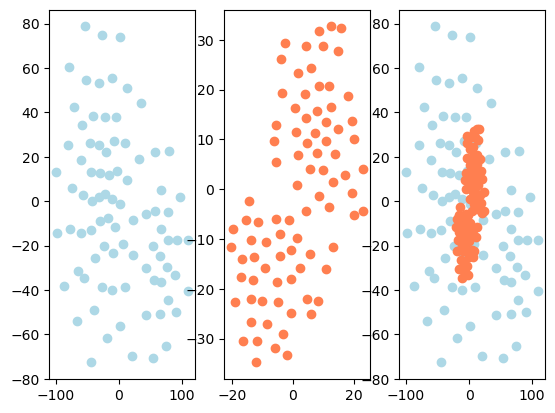

BATCH SIZE: 4
LEARNING_RATE: 0.0005
/Users/kalliehuynh/miniforge3/envs/env/lib/python3.10/site-packages/tensorflow/_api/v2/compat/v1/__init__.py


In [351]:
# Results
result = model.evaluate(testX, testY)
print("test acc:", result)


def generate_TSNE_all(predicted, true):
    """Generates a TSNE visualization of the predicted embeddings and the true embeddings
        Predicted embeddings are in coral, true are in light blue.
    Args:
        predicted : predicted embeddings
        true : true embeddings
    """
    model = TSNE(2)
    transformed_p = model.fit_transform(predicted)
    transformed_t = model.fit_transform(true)

    p_xs = transformed_p[:,0]
    p_ys = transformed_p[:,1]

    t_xs = transformed_t[:,0]
    t_ys = transformed_t[:,1]

    fig = plt.figure()

    plt.subplot(1, 3, 1)
    plt.scatter(t_xs, t_ys, c='lightblue')  # true are light blue

    plt.subplot(1, 3, 2)
    plt.scatter(p_xs, p_ys, c='coral')  # predicted are coral

    plt.subplot(1, 3, 3)
    plt.scatter(t_xs, t_ys, c='lightblue')  # true are light blue
    plt.scatter(p_xs, p_ys, c='coral')  # predicted are coral

    plt.show()




# Visible testing
samples = 5
print("Generate predictions for ", samples, " samples")
predictions = model.predict(testX[:samples])
print("predictions shape:", predictions.shape)
print('')
print('')

print('PREDICTED EMBEDDING')
for i in range(samples):
    closest_words = find_closest_embeddings(predictions[i])[:5] # Closest 5 words for each prediction
    print(df.loc[train_rows + i, ['c1', 'c2', 'cmp']], closest_words)
    # print(predictions[i])
    print('closest cosine distance to the prediction:', end=' ')
    print(spatial.distance.cosine(predictions[i], embeddings_dict[closest_words[0]]), end=', ')
    print(spatial.distance.cosine(predictions[i], embeddings_dict[closest_words[1]]))
print('')

# Generate TSNE viualization
# For all embeddings
labels = model.predict(testX)
words = data.iloc[train_rows:, 2]
features = np.array(data.iloc[train_rows:, 1540:], dtype="float32")

generate_TSNE_all(labels, features)

print('BATCH SIZE:', batch_size)
print('LEARNING_RATE:', learning_rate)

print(tf.__file__)


In [277]:

print('PREDICTED EMBEDDING')
for i in range(samples):
    closest_words = find_closest_embeddings(predictions[i])[:5] # Closest 5 words for each prediction
    print(df.loc[train_rows + i, ['c1', 'c2', 'cmp']], closest_words)
    # print(predictions[i])
    print('closest cosine distance to the prediction:', end=' ')
    print(spatial.distance.cosine(predictions[i], embeddings_dict[closest_words[0]]), end=', ')
    print(spatial.distance.cosine(predictions[i], embeddings_dict[closest_words[1]]))
print('')

PREDICTED EMBEDDING
c1         pit
c2        fall
cmp    pitfall
Name: 198, dtype: object ["john's", 'salesmen', 'half-hour', 'so-called', 'editorials']
closest cosine distance to the prediction: 0.09049880504608154, 0.0809059739112854
c1          button
c2           holes
cmp    buttonholes
Name: 199, dtype: object ['loopholes', 'pelts', 'prudence', 'negroes', 'mexicans']
closest cosine distance to the prediction: 0.002622067928314209, 0.13472837209701538
c1           master
c2           pieces
cmp    masterpieces
Name: 200, dtype: object ['vacations', 'u.s.', 'editorials', 'youngsters', 'articulate']
closest cosine distance to the prediction: 0.08895754814147949, 0.057797372341156006
c1         back
c2         side
cmp    backside
Name: 201, dtype: object ['roadside', 'articulate', "john's", "khrushchev's", 'dr.']
closest cosine distance to the prediction: 0.1001201868057251, 0.12751120328903198
c1          bride
c2          groom
cmp    bridegroom
Name: 202, dtype: object ['solid', 